In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py

In [2]:
from trajectory.params import  Block, Joint

j = Joint(5_000, 50_000)
b = j.new_block(100,123,456)

assert b.x == 100, b.x
assert b.v_0 == 123
assert b.joint.v_max == 5_000

b = j.new_block(100,123,456)

assert b.x == 100
assert b.v_0 == 123
assert b.joint.v_max == 5_000


(0.0, 6000.0)

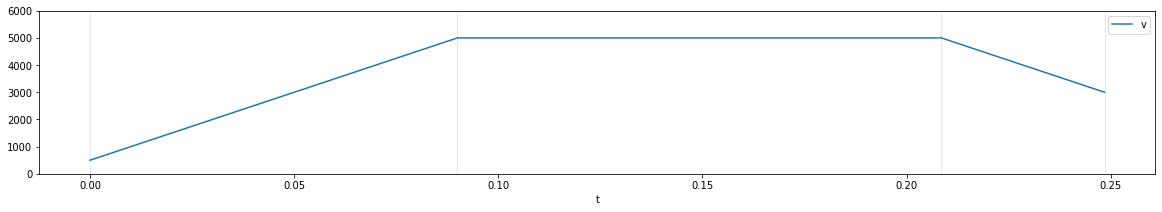

In [3]:
j = Joint(5_000, 50_000)
b = j.new_block(1000,500,3000).init()
assert round(b.area) == b.x, (b.area, b.x)

ax=plot_params(b)
ax.set_ylim(0,6000)


In [4]:
%%time 
# Test:
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm import tqdm

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert round(b.area) == b.x, (b, i)
            b.plan(b.t*tf)
            assert round(b.area) == b.x, (b, i, b.flag)

        except:
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)        

100%|██████████| 11520/11520 [01:07<00:00, 169.80it/s]


CPU times: user 1min 6s, sys: 919 ms, total: 1min 7s
Wall time: 1min 8s


In [5]:
df.qc.value_counts(normalize=True)

O1    0.784062
T0    0.129184
Z     0.050000
RV    0.015668
O2    0.014974
RT    0.004462
T     0.001649
Name: qc, dtype: float64

<AxesSubplot:xlabel='t'>

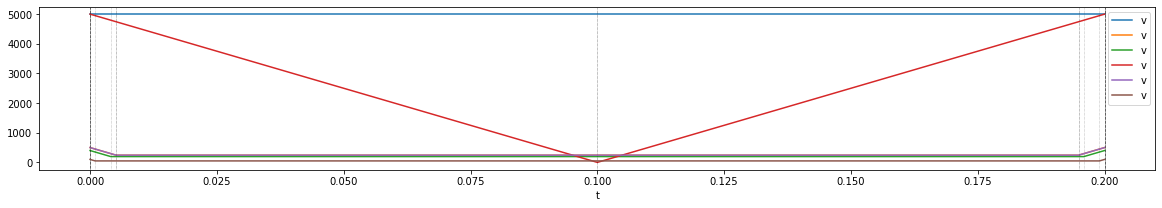

In [58]:
from copy import deepcopy

j = Joint(5_000, 50_000)

def plan_iter(blocks):
    
    sb = deepcopy(blocks) # save for later. 
    
    mt = max([ b.t for b in blocks])
    [b.plan(mt) for b in blocks]
    mt_new = max([ b.t for b in blocks])

    v_0_unchanged = all([ b1.v_0 == b2.v_0 for b1, b2 in zip(blocks, sb)])
    v_1_unchanged = all([ b1.v_1 == b2.v_1 for b1, b2 in zip(blocks, sb)])
    mt_unchanged = (mt_new == mt)
    
    assert all([ round(b1.area)==round(b2.area) for b1, b2 in zip(blocks, sb)])
    
    return  (v_0_unchanged and v_1_unchanged and mt_unchanged)
             
    
def plan_segment():
    
    moves = [ (x, v_max, v_max) for i, (x, v_0, v_1) in choices(limits(),k=6) ]
    
    blocks = [j.new_block(*args).init() for  args in moves]
    
    i = 0
    while True:
        if plan_iter(blocks):
            break
        i+=1
        print(i)
        assert i < 10
        
    return blocks
   
blocks = plan_segment()

#blocks = [ (b,) for b in blocks ]

plot_params(*blocks)

In [51]:
plot_params_df(*blocks)

,t,seg,axis,x,v_i,v_f,ss,del_t,v0m,v1m,calc_x,err
0,6.680000e-02,0,0,222.444000,5000.000000,1660.000006,a,6.680000e-02,0.0,0.0,0.0,0.0
1,2.168000e-01,0,0,249.000000,1660.000006,1660.000006,c,1.500000e-01,0.0,0.0,0.0,0.0
2,2.500000e-01,0,0,27.556000,1660.000006,0.000000,d,3.320000e-02,0.0,0.0,0.0,0.0
3,2.406504e-03,0,1,0.336519,200.000000,79.674794,a,2.406504e-03,0.0,0.0,0.0,0.0
4,2.484065e-01,0,1,19.600000,79.674794,79.674794,c,2.460000e-01,0.0,0.0,0.0,0.0
5,2.500000e-01,0,1,0.063481,79.674794,0.000000,d,1.593496e-03,0.0,0.0,0.0,0.0
6,3.111878e-02,0,2,53.276302,2490.000000,934.060933,a,3.111878e-02,0.0,0.0,0.0,0.0
7,2.313188e-01,0,2,186.999000,934.060933,934.060933,c,2.002000e-01,0.0,0.0,0.0,0.0
8,2.500000e-01,0,2,8.724698,934.060933,0.000000,d,1.868122e-02,0.0,0.0,0.0,0.0
9,2.995332e-09,0,3,0.000015,5000.000000,4999.999850,a,2.995332e-09,0.0,0.0,0.0,0.0


In [ ]:
j = Joint(5_000, 50_000)

n = 0
rows = []

for  i, (x, v_0, v_1) in choices(limits(),k=10_000):
    try:
        b = j.new_block(x, v_0, v_1).init()
        assert round(b.area) == x, (b, 1)

        d = dict(i=i, x=x, t=b.t,v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, v_c_2=None, qc=b.flag)
        
        b.plan(b.t)
        assert round(b.area) == x, (b, 1)
        d['v_c_2'] = round(b.v_c)
        d['pc'] = b.flag
        
        rows.append(d)

    except:
        print(n, i)
        raise
    n += 1
        
df = pd.DataFrame(rows)

assert len(df[ (df.v_c-df.v_c_2.round()) > 1]) == 0

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

j = Joint(5_000, 50_000)

n = 0
rows = []

for  i in range(1_000):
    
    x = max(randint(-100,3000), 0)
    v_0 = randint(0,v_max)
    v_1 = randint(0,v_max)
    
    try:
        b = j.new_block(x, v_0, v_1).init()
        assert round(b.area) == x, (b, 1)

        d = dict(i=i, x=x, t=b.t,v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, v_c_2=None, qc=b.flag)
        
        b.plan(b.t)
        assert round(b.area) == x, (b, 1)
        d['v_c_2'] = round(b.v_c)
        a_max = b.joint.a_max
        
        # This one works for all cases where v_c != v_max. from x_pent
        t, v_0, v_c,v_1 = (b.t, b.v_0, b.v_c, b.v_1)
        

        rows.append(d)

    except:
        print(n, i)
        raise
    n += 1
        
df = pd.DataFrame(rows)

assert len(df[ (df.v_c-df.v_c_2.round()) > 1]) == 0


In [ ]:
j = Joint(5_000, 50_000)

n = 0
rows = []
errors = []
for  i, (x, v_0, v_1) in choices(limits(),k=2_000):
    b = j.new_block(x, v_0, v_1).init()
    b.plan(b.t * 1.5)

    #if round(b.area) != x:
    #    print(i, b.v_0,b.v_c,b.v_1, b.area, x)
    
    d = dict(i=i, t=b.t, x1=x, x2=b.x, x3=b.area, v_0=b.v_0, v_c=b.v_c, v_1=b.v_1, flg=b.flag)
    rows.append(d)
    
    #assert round(b.area) == x, d
    
df = pd.DataFrame(rows)
df[df.x1.round() != df.x3.round()]

In [ ]:
v_max/2**6

In [ ]:
i,(x, v_0, v_1) = limits()[21249]
print(x, v_0, v_1)
b = j.new_block(x, v_0, v_1).init()


#b.v_1 = b.v_1//2
#b.v_0 = b.v_0


print(b.v_0, v_m, b.v_1)

b.plan(b.t * 1.6)

b.x, b.area


In [ ]:
i,(x, v_0, v_1) = limits()[118807]

b = j.new_block(x, v_0/2, v_1/2).init()
print(x, v_0, b.v_c, v_1)
b.plan(b.t * 1.6)
print(b.v_c, b.flag)
self = b
f = make_area_error_func(self.x, self.t, self.v_0, self.v_1, self.joint.v_max, self.joint.a_max)
dfe = pd.DataFrame([{'v_c':v_c, 'f':f(v_c)} for v_c in range(0,v_max)]).set_index('v_c')
ax=dfe.f.plot()
x, b.x, b.area, b.v_c, f(b.v_c)


In [ ]:
# Generate random basic profiles and check their area
from trajectory.trapmath import hex_v_c, hex_area_p
from trajectory.profiles import basic_profile, min_profile
from trajectory.plot import plot_params
from trajectory import ParameterError
import random
import pandas as pd

j = Joint(5_000, 50_000)

profiles = []
n_errors = 0
for i in range(10000):

    x = random.randint(20,300)
    v_0 = random.randint(0,v_max)
    v_1 = random.randint(0,v_max)
    
    try:
        p = min_profile(x, v_0, v_1, v_max, a_max)
        profiles.append(p)
        x_ = hex_area_p(p)
        
        if round(x) != round(p.x):
            print( x_, (x, v_0, v_1, v_max, a_max), (p.x, p.v_0, p.v_1))
            n_errors += 1
        
    except ParameterError as e:
        print(e, (x, v_0, v_1, v_max, a_max))
        n_errors += 1
        
    if n_errors > 10:
        break
        
assert n_errors  == 0

from random import choices
i = 0
for p in profiles:
    if p.v_c < 1500:
        #plot_params(p)
        i += 1
    if i > 5:
        break 

s = pd.DataFrame([ {'rc':p.recalcs} for p in profiles ])
s.describe()

In [ ]:
# Exhaustively test all combinations of velocities and velocity limits
# for init_parameters and update_boundary_velocities
%reload_ext autoreload
%autoreload 2
%run startup.py


ag = attrgetter(*'x t v_0 v_1 v_max a_max'.split())

velocities = [0,80,100,400,600,1000,2500,5000]
distances = [20,40,60,125,200,500,750,1000,5000]

errors = []
classes = []
params = []
profiles = []
n_errors = 0

for v_0, v_1 in product(velocities, velocities):
    for x in distances: 
        try:
            p = min_profile(x, v_0, v_1, v_max, a_max)
            profiles.append(p)
            x_ = hex_area_p(p)

            if round(x) != round(p.x):
                print( x_, (x, v_0, v_1, v_max, a_max), (p.x, p.v_0, p.v_1))
                n_errors += 1
        
            v_c = hex_v_c(*ag(p))
            assert round(v_c) == round(p.v_c), (v_c, p.v_c, p)
            p2 = update_params(p, p.t)
            assert p.x == p2.x

        
        except ParameterError as e:
            errors.append(e)
        except AssertionError as e:
            errors.append((e,p))
        except Exception as e:
            errors.append((e,p))


assert len(errors) == 0, len(errors)

s = pd.DataFrame([ {'rc':p.recalcs} for p in profiles ])


In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from random import choice 

step = 250
distances = list(range(10,2000,25))
velocities = list(range(0, v_max+step, step))
time_mult = [1.05, 1.1, 1.2, 1.6, 2, 10, 20]

profile_args = list(product(distances,velocities, velocities))
update_args = list(product(time_mult,velocities, velocities))

recs = []
errors = []
for _ in range(100_000):
    pa_i = randint(0, len(profile_args)-1)
    ua_i = randint(0, len(update_args)-1)
    
    (x, v_0, v_1) = profile_args[pa_i]
    (tm, v_0_new, v_1_new) = update_args[ua_i]
    
    try:
        p =  min_profile(x, v_0, v_1, v_max, a_max)
        t_= p.t
        p =  min_profile(p.x, v_0_new,v_1_new, p.v_max, p.a_max)
        t_ = max(t_, p.t)
        pu = update_params(p, t_*tm)
    except Exception as e:
        errors.append( (e, pa_i, ua_i) )
        #print( f'(x, v_0, v_1) = profile_args[{pa_i}]; (tm, v_0_new, v_1_new) = update_args[{ua_i}]')
        #raise
        
print(len(errors))
for e, pa_i, ua_i in errors[:10]:
    print( f'(x, v_0, v_1) = profile_args[{pa_i}]; (tm, v_0_new, v_1_new) = update_args[{ua_i}]  | {type(e)} {str(e)}')


In [ ]:
%%time 
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.trapmath import _calc_vc_min, calc_v_c_t

a_max = 50_000; v_max = 5_000

def run_vc_test(inputs):

    rows = []

    
    for i, (x, v_0, v_1) in inputs: #choices(list(product(distances, velocities, velocities)), k=100000):

        v_0, v_c, v_1, x_a, t_a, x_d, t_d, r = _calc_vc_min(x, v_0, v_1, v_max, a_max)

        x_c = x - (x_a+x_d)
        t_c = x_c/v_c if v_c != 0 else 0
        t = t_a + t_c + t_d

        assert round(x_c) >= 0 , (x_c, r)

        x_calc = hex_area(t, v_0, v_c, v_1, a_max)

        recalc_v_c, qc = calc_v_c_t(x, t+0.01, v_0, v_1, v_max, a_max)

        rows.append(dict(i=i, x=x, t=t, x_calc=x_calc, v_0=v_0, v_c=v_c, r_v_c=recalc_v_c, v_1=v_1,  flg=r, qc=qc))

    df = pd.DataFrame(rows) 
    df['v_m'] = (df.v_0+df.v_1)/2
    df['v_d'] = (df.v_0-df.v_1).abs()
    df['v_m_t'] = (df.v_0+df.v_1)/df.x
    df['x_calc'] = df.x_calc.round().astype(int)
    
    return df

distances =  [0] + list(range(50,2000, 25))
velocities = list(range(0,5000, 50))+[249,251, 4999, v_max]
inputs = list(enumerate(product(distances, velocities, velocities)))

df = run_vc_test(inputs)

assert len(df[df.x != df.x_calc]) == 0
assert len(df[df.qc=='E']) == 0

print(len(df))
df.sample(20).head()

In [ ]:
inputs = [ (i,(randint(0,2000), randint(0,v_max),randint(0,v_max))) for i in range(10_000) ]
df = run_vc_test(inputs)

assert len(df[df.x != df.x_calc]) == 0
assert len(df[df.qc=='E']) == 0

print(len(df))
df.sample(20).head()

In [ ]:
from collections import Counter 
def update_params_accel(p, t, v_0=None):
    """Update a block to a specific time, and into an accel 
    form, with no decel phase. """

    v_0 = p.v_max if v_0 is None else v_0

    a_max = p.a_max
    
    # no decel: v_1 == v_c
    v_c = a_max * t + v_0 - sqrt(p.a_max * (p.a_max * t ** 2 + 2 * t * v_0 - 2 * p.x))
    v_c = min(v_c, p.v_max)
    x_a, t_a = accel_xt(v_0, v_c, p.a_max)
    
    if x_a > p.x:
        # It's just a triangle, no cruise
        v_c = sqrt(2*p.a_max*p.x + v_0**2)
        x_a, t_a = accel_xt(v_0, v_c, p.a_max)
        assert round(x_a) >= round(p.x), (x_a, p.x)
    
    x_c = p.x - x_a
    t_c = x_c/v_c
    
    p = p.replace(t=t_a + t_c, x= x_a + x_c,
                  x_a=x_a, x_c=x_c, x_d=0,
                  t_a=t_a, t_c=t_c, t_d=0,
                  v_0=v_0, v_c=v_c, v_1=v_c)
    return p

cls = []
for _ in range(100_000):
    pa_i = randint(0, len(profile_args)-1)
    ua_i = randint(0, len(update_args)-1)
    
    (x, v_0, v_1) = profile_args[pa_i]
    (tm, v_0_new, v_1_new) = update_args[ua_i]
    
    p =  min_profile(x, v_0, v_1, v_max, a_max)
    p2 = update_params_accel(p, p.t)
    cls.append(classify(p))

    assert round(p.x) ==  round(hex_area_p(p2))
   
Counter(cls)

In [ ]:
# Test simple updating between pairs of blocks

%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000

step = 1_000
velocities = list(range(0, v_max+step, step))

vp = list(product(velocities, velocities))
keys = 'v_0 v_1'.split()

#v_args_a =  [dict(zip(keys, v)) for v in vp]
v_args_a =  [dict(v_0=v[0], v_1=v_max) for v in vp]
v_args_b =  v_args_a[-1:] + v_args_a[:-1]
v_args_c =  v_args_a[1:]  + v_args_a[:1]

records= []

def ip(args_a, args_b, args_c):
    return [min_profile(randint(10,2000),**args_a, v_max=v_max, a_max = a_max) for _ in range(3)]


for i,(args_a, args_b, args_c) in enumerate(zip(v_args_a, v_args_b, v_args_c)):
    records.append(ip(args_a, args_b, args_c))
   
def update_pair(p,n,t):
    ag_mp = attrgetter(*'x v_0 v_1 v_max a_max'.split())

    v_0 = p.v_0
    v_1 = p.v_1
    p_t = p.t
     
    # Remake the profile
    # n = min_profile(*ag_mp(n.replace(v_0=p.v_1)))
    # expand the time
    
    n = update_params(n, max(t, n.t), v_0=p.v_1)
    
    for i in range(4):
        
        v_m = (p.v_1+n.v_0)/2
        p = min_profile(*ag_mp(p.replace(v_1=v_m)))
        n = min_profile(*ag_mp(n.replace(v_0=v_m)))

        n = update_params(n, max(t, n.t))
        p = update_params(p, p.t)
        
        if p.v_1 == n.v_0 and p.v_1 == v_m:
            break
        
    return i, p,n

counts = []
for i,r in enumerate(records):
    z, p,n = update_pair(r[0],r[1], r[1].t*1.5)
    counts.append(z)
    #plot_adj(p,n)

In [ ]:
pd.Series(counts).describe()

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000

n_joints = 3
segs = [ [min_profile(0,0,0, v_max, a_max) for _ in range(n_joints)] ]

def update_pair(p,n,t):
    ag_mp = attrgetter(*'x v_0 v_1 v_max a_max'.split())

    v_0 = p.v_0
    v_1 = p.v_1
    p_t = p.t
     
    # Remake the profile
    # n = min_profile(*ag_mp(n.replace(v_0=p.v_1)))
    # expand the time
    
    n = update_params(n, max(t, n.t), v_0=p.v_1)
    
    for i in range(4):
        
        v_m = (p.v_1+n.v_0)/2
        p = min_profile(*ag_mp(p.replace(v_1=v_m)))
        n = min_profile(*ag_mp(n.replace(v_0=v_m)))

        n = update_params(n, max(t, n.t))
        p = update_params(p, p.t)
        
        if p.v_1 == n.v_0 and p.v_1 == v_m:
            break
        
    return i, p,n

def last_v1():
    if len(segs) == 0:
        return [0] * n_joints
    else:
        return [p.v_1 for p in segs[-1] ]

for i in range(10):
    seg = [min_profile(randint(10,2000),v_0, v_max, v_max, a_max) for v_0 in last_v1()]
    
    min_t = max([p.t for p in seg])
    calcs, p, n = zip(*[update_pair(p,n,min_t) for p, n in zip(segs[-1],seg)])
    
    segs.append(n)

ss = copy(segs)
    
with open('segments.pickle', 'wb') as f:
    pickle.dump((segs, seg), f, pickle.HIGHEST_PROTOCOL)
 
plot_params(*segs[1:8] )    

In [ ]:
#for i, (p, n) in enumerate(zip(segs[-1],seg)):
#    print(i)

p, n = list(zip(segs[-1],seg))[2]
update_pair(p,n,min_t)


In [ ]:
# Exhaustively test all combinations of velocities and velocity limits
# for init_parameters and update_boundary_velocities

from itertools import product 

a_max = 50_000
v_max = 5_000

step = 1_000
velocities = list(range(0, v_max+step, step))

vp = list(product(velocities, velocities))
keys = 'v_0 v_1'.split()

v_args_a =  [dict(zip(keys, v)) for v in vp]
v_args_b =  v_args_a[-1:] + v_args_a[:-1]
v_args_c =  v_args_a[1:]  + v_args_a[:1]

records= []
inputs = []

def ip(args_a, args_b, args_c):
    """Make three adjacent joints"""
    
    return [min_profile(randint(10,2000),**args_a, v_max=v_max, a_max = a_max) for _ in range(3)]


for i,(args_a, args_b, args_c) in enumerate(zip(v_args_a, v_args_b, v_args_c)):
    g  =[]
    inp = []
    
    
    a,b,c = ip(args_a, args_b, args_c)
    inp.append( (a,b,c) )
    update_boundary_velocities(a,b,c)
    g.append( (a,b,c) )
    
    a,b,c = ip(args_a, args_b, args_c)
    inp.append((None,a,b) )
    update_boundary_velocities(None,a,b)
    g.append((None,a,b) )
    
    a,b,c = ip(args_a, args_b, args_c)
    inp.append( (a,b, None) )
    update_boundary_velocities(a,b, None)
    g.append( (a,b, None) )
    
    records.append(g)
    inputs.append(inp)

for i,s in enumerate(records):
    for j, (a, b, c) in enumerate(s):
    
        assert a is None or a.v_1 == b.v_0, (i,j, a.v_1, b.v_0)

        def _f(p):
            assert p is None or p.v_0 <= p.v_0_max, (i,j, p.v_0, p.v_0_max)
            assert p is None or p.v_1 <= p.v_1_max, (i,j, p.v_1, p.v_1_max)
            assert p is None or p.v_0 >= p.v_0_min, (i,j, p.v_0, p.v_0_min)
            assert p is None or p.v_1 >= p.v_1_min, (i,j, p.v_1, p.v_1_min)

        _f(a)
        _f(b)
        _f(c)

In [ ]:
# Check that initial_parameters produces reasonable values for 
# many conditions.
from random import randint, random
from trajectory.trapmath import classify, min_time_parameters, hex_v_c, hex_area
import pandas as pd
from math import sqrt

segments = []
v_max = 5_000
a_max = 50_000

error_p = []
all_p = []
for _ in range(1_000):
    
    err = None
    x_recalc = None
    v_c = None 
    t = None 
    
    x_i = max(randint(-500,1000), 0)
    x_i = x_i if x_i > 100 else 0  # Minimum value of 100, or 0
    
    v_0 = min(max(randint(-3000, v_max+2000), 0),v_max)
    v_1 = min(max(randint(-3000, v_max+2000), 0),v_max)

    t = None
    cls2 = None
    x_recalc = None

    p = init_parameters(x_i, v_0, v_1,  v_max, a_max) 
    all_p.append(p)
    
    assert p.ip is not None
    assert p.v_1 is not None
    assert p.v_0 is not None
    assert p.t is not None, (x_i, v_0, v_1,  v_max, a_max) 
    
    v_c = hex_v_c(x_i, p.t, p.v_0, p.v_1, v_max, a_max)
    try:
        x_recalc = hex_area(p.t, p.v_0, v_c, p.v_1, a_max)
    except Exception as e:
        error_p.append(p)
        err = f'{type(e)} {str(e)}'
        x_recalc = -1 


    segments.append({
        'x_i': x_i,
        'x_recalc': x_recalc,
        't': p.t,
        'v_0_i': v_0,
        'v_0_p': p.v_0 if p else None,
        'v_c_p': p.v_c if p else None,
        'v_c': v_c,
        'v_1_i': v_1,
        'v_1': p.v_1 if p else None,
        'v_max': v_max,
        'a_max': a_max,
        'err': err
    })
    
segments = pd.DataFrame(segments)

for c in ('x_i','x_recalc','v_0_i','v_0_p','v_c','v_c_p','v_1','v_1_i','v_max'):
    pass
    try:
        segments[c] = segments[c].fillna(-1).round(0).astype('Int64')
    except Exception as e:
        print(c, e)
 

# RMS error from x_i to x_p
segments['err_x'] = (segments.x_i-segments.x_recalc).abs()
print(f"RMS error for x_calc-x_recalc: {sqrt((segments[segments.err.isnull()].err_x**2).mean())}")

x_errors = segments[(segments.err_x > 10) & (segments.err.isnull()) & (segments.x_recalc != -1) ]

ex_errors = segments[(segments.err_x > 10) & (~segments.err.isnull())] # x_errors and exceptions

print(f"{len(x_errors)} x errors, {len(ex_errors)} exception errors")

display(segments)

assert len(segments[(segments.v_c_p == -1) & (segments.x_i != 0)]) == 0 # v_c_p can == -1 b/c of fill(-1) above
assert len(x_errors) == 0
assert len(ex_errors) == 0, len(ex_errors)


In [ ]:
for p in error_p:
    try:
        v_c = hex_v_c(p.x, p.t, p.v_0, p.v_1, v_max, a_max)
        x_recalc = hex_area(p.t, p.v_0, v_c, p.v_1, a_max)
    except Exception as e:
        print(e)
        print(p)
        break

In [ ]:
from itertools import islice

def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk
        
for g in islice(grouper(3, all_p), 10):
    mt = max([p.t for p in g])
    if mt == 0:
        continue
    
    print(mt)
    


In [ ]:
from operator import attrgetter
from copy import copy
df = pd.read_csv('limits.csv', header=[0,1])

# keys = 'v_0 v_1 v_0_max v_1_max'.split()
common = dict(v_max=v_max, a_max = a_max)

ag = attrgetter(*'v_0 v_1 updated_v_0 updated_v_1'.split())

def mtp(r, axis):
    a= r.loc[axis]
    return min_time_parameters(a.x*500, v_0=a['0']*1000, v_1=a['1']*1000, **common)

def update(r,axis,p):
    
    r[(axis,'v0')] = int(p.v_0)
    r[(axis,'v1')] = int(p.v_1)
    r[(axis,'mv0')] = int(p.v_0_max)
    r[(axis,'mv1')] = int(p.v_1_max)

 
rows = []
for idx, r in df.iterrows():

    a,b,c = mtp(r, 'a'),mtp(r, 'b'),mtp(r, 'c')
    
    update_boundary_velocities(a,b,c)
    #assert     all([j.updated_v_0 for j in (a,b,c)])
    #assert not all([j.updated_v_1 for j in (a,b,c)])

    update(r, 'a',a); update(r, 'b',b); update(r, 'c',c)
    rows.append(r)

    
pd.DataFrame(rows)

In [ ]:
# Test the error of the min_time_parameters() function with a lot of random records

from trajectory.planner import accel_tx,  min_time_parameters
from tqdm import tqdm 

from random import randint, random


adjustments = 0
rows = []
for i in tqdm(range(10000)):

    v_max = 5_000 #randint(300,10_000)
    a_max = 50_000 # randint(v_max*15,v_max*25)
    
    x = randint(10,v_max)
    v_0 = randint(0,v_max)
    v_1 = randint(0,v_max)
    
    args = (x, v_0, v_max, v_1, v_max, a_max)
    d = { k:v for k,v in zip('x_in v_0_in v_c_in v_1_in v_max a_max'.split(),args)}
        
    r = min_time_parameters(x, v_0, v_1, v_max, a_max)

    d.update(r.asdict())
    d['exc'] = ''
        
    rows.append(d)
        
df = pd.DataFrame(rows)
df['x'] = df.x.round().astype(int)
# df['x_r'] = (df.x_a + df.x_c + df.x_d).round().astype(int) # This appears to be always true
df['eq'] = df.x_in == df.x
df['err'] =  ((df.x_in - df.x).abs()/df.x_in) 

assert df.err.mean()< 0.01 , df.err.mean()
assert len(df[df.err > 1]) == 0

def _hvc(*args):
    try:
        return hex_v_c(*args)
    except Exception:
        return -1

def _ha(*args):
    try:
        return hex_area(*args)
    except Exception:
        return -1
    
v_c = [ _hvc(r.x, r.t, r.v_0, r.v_1, r.v_max, r.a_max)for idx, r in df.iterrows()]
df['v_c_pa'] = v_c
df['v_c_err'] =  (df.v_c-df.v_c_pa).abs()   
df['ha'] =  [ _ha(r.t, r.v_0, r.v_c_pa, r.v_1, r.a_max)for idx, r in df.iterrows()]
df['ha_e'] = (df.x-df.ha).abs()

df

In [ ]:
df[df.ha == -1]

In [ ]:
joint = Joint(5_000, 50_000)
N = 6
joints = [joint]*N


segments = []

def last_v_1(segments):
    
    if len(segments):
        return [j.v_1 for j in segments[-1] ]
    else:
        return [0]*len(joints)

for i in range(10):
    
    s = [ min_time_parameters(randint(0,j.v_max), v_1, 0, j.v_max, j.a_max) for j,v_1 in zip(joints,last_v_1(segments) ) ]
    
    # Calculate segment minimum time. 
    
    mt1 = max([e.t_min for e in s])
    
    # Re-calc the min-time parameters, for a fresh start
    mtp = [min_time_parameters(r.x, r.v_0, r.v_1, r.v_max, r.a_max) for r in s]
    mt2 = max(e.t_min for e in mtp) # Get our new, fresh min time, which should be the same as in mt1
    assert( round(mt1, 5) == round(mt2, 5) )
    
    # Calcluate the final v_c parameter now that we have the segment time
    v_c_6 = [ hex_v_c(r.x, mt2, r.v_0, r.v_1, r.v_max, r.a_max) for  r in  s ]
    
    # Make sure the areas still work
    x_6 =  [ hex_area(mt2, r.v_0, v_c, r.v_1, r.a_max) for v_c,r in  zip(v_c_6, s) ]
    
    assert all([ abs(x-r.x)<1 for x, r in zip(x_6, s) ]), [ (round(x),round(r.x)) for x, r in zip(x_6, s) ]
    
    segments.append(s)
    
    
    prior = segments[-2] if len(segments)>1 else None
    next_ = None

    for i in range(3):
        r = update_segment_window(prior, s, next_)
        print(r)
    print('---')
    


In [ ]:
## Test joint windows

j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,0,500])
s = sl.rmove([1000,1000,1000])

p,c,n = sl.get_window(-1)

assert all([e is not None for e in p]) 
assert all([e is not None for e in c]) 
assert all([e is     None for e in n]) # Next is empty on last

p,c,n = sl.get_window(-2)

assert all([e is not None for e in p]) 
assert all([e is not None for e in c]) 
assert all([e is not None for e in n]) 

p,c,n = sl.get_window(-3)

assert all([e is     None for e in p]) 
assert all([e is not None for e in c]) 
assert all([e is not None for e in n]) 

p,c,n


In [ ]:
from operator import attrgetter
j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([1000,1000,1000])
s = sl.rmove([0,   500, 1000])
s = sl.rmove([1000,1000,1000])


def _f(index):

    p,c,n = sl.get_window(index)

    update_segment(p)
    update_segment(c)
    update_segment(n)

    min_idx = -1
    for e in zip(p,c,n):
        idx, u = update_boundary_velocities(*e)
        print(' ',u)
        min_idx = min(min_idx, idx)

        
    index += idx
    
    return index
ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_0_max v_1_max'.split())
index = _f(-1)
print(ag(sl[1][2].p), hex_area(*ag_ha(sl[1][2].p)))
index = _f(-1)
print(ag(sl[1][2].p), hex_area(*ag_ha(sl[1][2].p)))
sl.plot(); plt.show()

In [ ]:
index = -1
for i in range(5):
    index = _f(index)
    print (index)
    sl.plot(); plt.show()
    print(sl)
    if index == 0:
        break
    
    
display(sl.dataframe)

In [ ]:
# Test random segments, without segment-to-segment interactions


joints = [, Joint(5_000, 50_000), Joint(5_000, 50_000)]
sl = SegmentList(joints)   

inputs = []
for i in range(N):
    moves = [randint(-2000,2000) for _ in sl.joints] 

    limits = []
    for j in sl.joints:
        v_0_max = randint(0,j.v_max)
        v_0 = randint(0,j.v_max)
        v_1_max = randint(0,j.v_max)
        limits.append( (v_0_max, v_0 , v_1_max) )
        
    inputs.append( (moves, limits) )
      

In [ ]:
from trajectory.exceptions import ValidationError, ConvergenceError      
frames = []

def test_sl(moves, limits):
   
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    s = sl.rmove(moves)  
    
    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max
        
    s.update()
    
    sl.validate()
    
    return s


for i, (moves, limits) in enumerate(inputs):

    try:
        s = test_sl(moves, limits)
        
        v_0_in = [e[1] for e in limits]
        v_0_out = [js.v_0 for js in s]
        
        frames.append(s.params)
    except Exception as e:
        print('E ', type(e), i, e)

df = pd.concat(frames)
df[df.err_x > 1].sort_values('err_x', ascending=False)

In [ ]:
from trajectory.planner import max_v0_for_x

def run_segment(moves, limits, update=True):
    from trajectory.exceptions import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    
    s = sl.rmove(moves, update = update)  

    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max   
    
    return sl


sl = run_segment([250,3000], [(5000, 5000, 0), (5000, 5000, 5000)], False)
sl.update()

plot_segment_list(sl.dataframe)
sl.dataframe

In [ ]:
sl = run_segment([500,3000], [(0, 0, 0), (5000, 5000, 0)])
sl.update()
plot_segment_list(sl.dataframe)
sl.dataframe


# Classification

In [ ]:
from collections import defaultdict
from random import shuffle
from trajectory.planner import classify, kind_icon_map

a_max= 50_000
v_max = 5_000


# Make new classification tests
dd = defaultdict(set)
for _ in range(10_000):
    x = max(randint(-500,1000), 0)
    v_0 = min(max(randint(-3000, v_max+2000), 0), v_max)
    v_1 = min(max(randint(-3000, v_max+2000), 0), v_max)
    args = (x, v_0, v_1, v_max, a_max)
    r = classify(*args)
    
    dd[r].add(args)

# Make the class_test list
l = []
for k, s in dd.items():
    s = list(s)
    shuffle(s)
    for v in s[:10]:
        l.append((v,k.name))
  
# Create a map from each classification to a set
# of values that has the (min, max) values for each parameter that produce that
# classification
min_max = {}
rows  = []
arg_names = 'x v_0 v_1 v_max, a_max'.split()
for k, s in dd.items():
    z = list(zip(*list(s)))
    z_min = [min(e) for e in z]
    z_max = [max(e) for e in z]
    
    min_max[k] =  list(zip(z_min, z_max))[:3]
    
    d = { 'name': k.name }
    for arg, mn, mx in list(zip(arg_names, z_min, z_max))[:3]:
        d[arg+'_min'] = mn
        d[arg+'_max'] = mx
    
    rows.append(d)
    
min_max_df = pd.DataFrame(rows)
min_max_df


In [ ]:
#  (x, v_0, v_1, v_max, a_max) 
class_test = [
 ((991, 3270, 2029, 5000, 50000), 'PENTAGON'),
 ((491, 4113, 5000, 5000, 50000), 'PENTAGON'),
 ((646, 3407, 4052, 5000, 50000), 'PENTAGON'),
 ((985, 1309, 4067, 5000, 50000), 'PENTAGON'),
 ((944, 4496, 1129, 5000, 50000), 'PENTAGON'),
 ((606, 2337, 2051, 5000, 50000), 'PENTAGON'),
 ((514, 1783, 2992, 5000, 50000), 'PENTAGON'),
 ((560, 3763, 556, 5000, 50000), 'PENTAGON'),
    
 ((4000, 0, 0, 5000, 50000), 'TRAPZEZOID'),
 ((546, 0, 0, 5000, 50000), 'TRAPZEZOID'),
    
 ((173, 3548, 3826, 5000, 50000), 'TROUGH'),
 ((188, 4335, 425, 5000, 50000), 'TROUGH'),
 ((30, 1732, 1732, 5000, 50000), 'TROUGH'),
 ((25, 1581, 1581, 5000, 50000), 'TROUGH'),
 ((7, 405, 836, 5000, 50000), 'TROUGH'),
 ((13, 765, 1140, 5000, 50000), 'TROUGH'),
 ((1, 316, 316, 5000, 50000), 'TROUGH'),
 ((10, 1000, 1000, 5000, 50000), 'TROUGH'),
    
 ((289, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((369, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((71, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((252, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((305, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((133, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((390, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((434, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((231, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((281, 0, 0, 5000, 50000), 'TRIANGLE'),
    
 ((629, 0, 3151, 5000, 50000), 'ACEL'),
 ((918, 0, 4129, 5000, 50000), 'ACEL'),
 ((299, 0, 1317, 5000, 50000), 'ACEL'),
 ((576, 0, 570, 5000, 50000), 'ACEL'),
 ((784, 0, 2494, 5000, 50000), 'ACEL'),
 ((393, 0, 188, 5000, 50000), 'ACEL'),
 ((618, 0, 4152, 5000, 50000), 'ACEL'),
 ((862, 0, 1289, 5000, 50000), 'ACEL'),
 ((71, 0, 1392, 5000, 50000), 'ACEL'),
 ((123, 0, 3507, 5000, 50000), 'ACEL'),
    
 ((545, 441, 0, 5000, 50000), 'CLIFF'),
 ((987, 3106, 0, 5000, 50000), 'CLIFF'),
 ((836, 2502, 0, 5000, 50000), 'CLIFF'),
 ((418, 558, 0, 5000, 50000), 'CLIFF'),
 ((559, 904, 0, 5000, 50000), 'CLIFF'),
 ((202, 1662, 0, 5000, 50000), 'CLIFF'),
 ((270, 5000, 0, 5000, 50000), 'CLIFF'),
 ((257, 1856, 0, 5000, 50000), 'CLIFF'),
 ((381, 3522, 0, 5000, 50000), 'CLIFF'),
 ((869, 2426, 0, 5000, 50000), 'CLIFF'),
    
 ((115, 5000, 0, 5000, 50000), 'DECEL'),   
 ((25, 1785, 0, 5000, 50000), 'DECEL'),
 ((53, 5000, 0, 5000, 50000), 'DECEL'),
 ((35, 2898, 0, 5000, 50000), 'DECEL'),
 ((66, 4563, 0, 5000, 50000), 'DECEL'),
 ((100, 4458, 0, 5000, 50000), 'DECEL'),
 ((87, 5000, 0, 5000, 50000), 'DECEL'),
 ((42, 4511, 0, 5000, 50000), 'DECEL'),
    
 ((0, 0, 3438, 5000, 50000), 'ZERO'),
 ((0, 4255, 4443, 5000, 50000), 'ZERO'),
 ((0, 2960, 2762, 5000, 50000), 'ZERO'),
 ((0, 259, 116, 5000, 50000), 'ZERO'),
 ((0, 326, 1424, 5000, 50000), 'ZERO'),
 ((0, 3923, 0, 5000, 50000), 'ZERO'),
 ((0, 0, 3739, 5000, 50000), 'ZERO'),
 ((0, 4587, 1189, 5000, 50000), 'ZERO'),
 ((0, 2137, 5000, 5000, 50000), 'ZERO'),
 ((0, 2911, 0, 5000, 50000), 'ZERO')]

# These record produce a high x error when 
# recalculating the area
class_test_he = [
 ((193, 1018, 4588, 5000, 50000), 'TROUGH'), 
 ((233, 1029, 2812, 5000, 50000), 'TROUGH'), 
 ((218, 3779, 0, 5000, 50000), 'DECEL'),
 ((109, 2709, 0, 5000, 50000), 'DECEL')
]

In [ ]:
output = []
for args, name in class_test:
    assert classify(*args).name == name,  (classify(*args).name, name)
    output.append( (args,  classify(*args).name) )


In [ ]:
from trajectory.trapmath import *
    
rows = []
v_max = 5_000
a_max = 50_000
av = (v_max, a_max)

for _ in range(1_000):
    x = max(randint(-500,1000), 0)
    v_0 = min(max(randint(-3000, av[0]+2000), 0), av[0])
    v_1 = min(max(randint(-3000, av[0]+2000), 0), av[0])
    
    args = (x, v_0, v_1, v_max, a_max)
    
    err = None
    try:
        p = min_time_parameters(x, v_0, v_1, v_max, a_max)
    except AssertionError as e:
        p = Params(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, InputParams(x, v_0, v_1, a_max, 0))
        err = f"{type(e)} {e}"
        print(args)
        raise
    except TrapMathError as e:
        p = Params(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, InputParams(x, v_0, v_1, a_max, 0))
        err = f"{type(e)} {e}"
        
    d = p.asdict()
    del d['ip']
    d['err'] = err
    rows.append(d)
    
mtp = pd.DataFrame(rows)
mtp.head()